# &#x1F4F6; [Demodulation of the 5G NR downlink](https://destevez.net/2023/08/demodulation-of-the-5g-nr-downlink/)

In [1]:
file_path = "catkira/1876954_7680KSPS_srsRAN_Project_gnb_short.sigmf-data"
x = read!(file_path, Array{Int32}(undef, 2200544));

In [2]:
 @show size(x), x[1];

(size(x), x[1]) = ((2200544,), 106496)


In [3]:
𝑓ₛ = 7.68e6

# This should be the nominal RF frequency of the subcarrier that we use as DC for demodulation
# (used for NR phase compensation)
f_dc = 1.87695e9

# these are in units of samples and depend on 𝑓ₛ
Tu = 512
Ncp = div(144, 4)
Ncpl = div(144 + 16, 4)

40

In [4]:
# phase correction to apply to symbols 0, 1, 2, 3, 4, 5, 6 in a 0.5 ms interval
p₀ = (f_dc .* (0:6) .* (Tu + Ncp)) / 𝑓ₛ
p₁ = p₀ .% 1
phase_corr = exp.(1im * 2 * π * p₁); # @show phase_corr;

In [5]:
cfo = 18.88  # Hz
ϕ₀ = -2.97  # radians
sfo = -3.2e-6  # parts per one
sto_fine = 12.4e-9  # seconds

1.24e-8

In [6]:
# Amplitude adjustment to get symbols of unity amplitude
x = (x[1:2:end] + im * x[2:2:end]) / 2^31 * 24.7; # @show x[1,:];


In [7]:
# Correct for CFO and phase offset
x .*= exp.(-1im * (2 * π * cfo/𝑓ₛ * (1:length(x)) .+ ϕ₀)); # @show x[1,:];

## Poor man's Schmidl & Cox

In [8]:
cp_corr = zeros(ComplexF64, round(Int, 𝑓ₛ * 0.4e-3)); # @show size(cp_corr);
corr_start = round(Int, 9.05e-3 * 𝑓ₛ); # @show corr_start;
for j in 1:length(cp_corr)
    y = x[corr_start + j:corr_start + j + Ncp + Tu - 1]
    cp_corr[j] = sum(y[1:Ncp] .* conj.(y[end-Ncp+1:end]))
end

t_corr = 1e3 * (collect(1:length(cp_corr)) .+ corr_start) / 𝑓ₛ; # @show t_corr[1];

In [9]:
using Plots
using LaTeXStrings

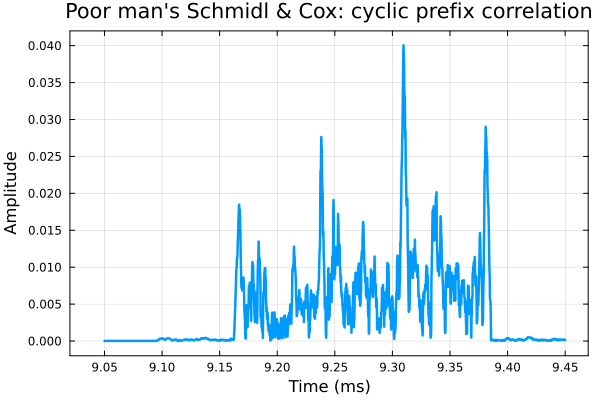

In [10]:
plot(t_corr, abs.(cp_corr)
    , xlabel = "Time (ms)"
    , ylabel = "Amplitude"
    , title = "Poor man's Schmidl & Cox: cyclic prefix correlation"
    , legend = :false
    , ylims = [-0.002,0.042]
    , xlims = [9.02,9.47]
    , yticks = 0.000:0.005:0.045
    , xticks = 9.00:0.05:9.50
    , linewidth = 2.5
    , framestyle = :box
)

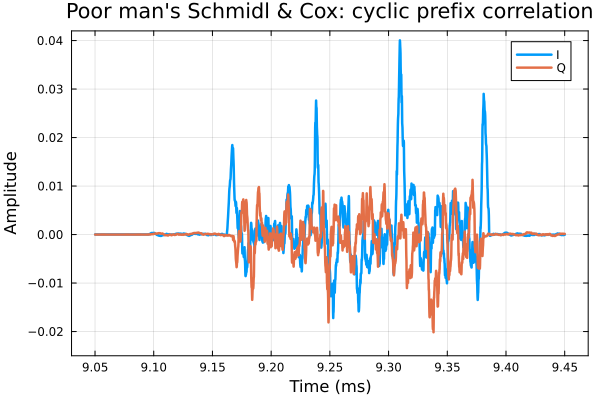

In [11]:
plot(t_corr, real.(cp_corr)
    , xlabel="Time (ms)"
    , ylabel="Amplitude"
    , title="Poor man's Schmidl & Cox: cyclic prefix correlation"
    , label="I"
    , ylims=[-0.025,0.042]
    , xlims=[9.03,9.47]
    , yticks = -0.02:0.01:0.045
    , xticks = 9.00:0.05:9.50
    , linewidth = 2.5
    , grid = :true
    , legend = :topright
    , framestyle = :box
)
plot!(t_corr, imag.(cp_corr)
    , label="Q"
    , linewidth=2.5
)

In [12]:
m₀ = argmax(abs.(cp_corr[1:1001]))
m₁ = argmax(abs.(cp_corr[1001:1501])) + 1000
m₂ = argmax(abs.(cp_corr[1501:2251])) + 1500
m₃ = argmax(abs.(cp_corr[2251:end])) + 2250;

In [13]:
# @show [m₀, m₁, m₂, m₃];
# @show cp_corr[[m₀, m₁, m₂, m₃]];
# @show (𝑓ₛ / Tu); 

In [14]:
CFO_est = -angle.(cp_corr[[m₀, m₁, m₂, m₃]]) / (2 * π) * (𝑓ₛ / Tu); # @show CFO_est;

## PSS demodulation

In [15]:
using FFTW, DSP

In [16]:
# Start demodulation at the middle of the cyclic prefix for maximum robustness to STO
a₀ = corr_start + m₀ + div(Ncp, 2); # @show a₀, corr_start, m₀, div(Ncp,2)

𝐹ₓ = DSP.fftshift(DSP.fft(x[a₀:(a₀+Tu)-1])); # @show size(𝐹ₓ), 𝐹ₓ[1];
# Correct for the 5G NR upconversion discontinuity
# This PSS is transmitted on symbol 2 mod 7
𝐹ₓ .*= phase_corr[3]; # @show phase_corr[3], 𝐹ₓ[1];
# tu_fft = ; @show Tu, size(tu_fft), tu_fft[1];
# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
𝐹ₓ .*= exp.(1im * 2π .* DSP.fftshift(DSP.fftfreq(Tu)) * Ncp / 2); # @show 𝐹ₓ[1], size(𝐹ₓ);

In [17]:
# The PSS ocuppies subcarriers 56 to 128 relative to the start of an SS/PBCH block
# In this case, the SS/PBCH block starts at subcarrier -120 (with respect to the
# subcarrier we have decided to treat as DC). This means that the SS/PBCH block is
# not centred with respect to this choice of DC (but this doesn't matter).
pss_sc_sel = range(Int(Tu/2-120+57), Int(Tu/2-120+56+127))

193:319

In [18]:
# x_all_sc = np.arange(f.size) - Tu//2; y_all_sc = 10*np.log10(np.abs(f)**2);
x_all_sc = collect(0:size(𝐹ₓ,1)-1) .- div(Tu, 2); y_all_sc = 10 * log10.(abs2.(𝐹ₓ));
# @show x_all_sc[1], y_all_sc[1]; @show length(x_all_sc)

In [19]:
# x_pss_sc = np.arange(f.size)[pss_sc_sel] - Tu//2; y_pss_sc = 10*np.log10(np.abs(f[pss_sc_sel])**2)
x_pss_sc = collect(0:size(𝐹ₓ,1)-1)[pss_sc_sel] .- div(Tu, 2); y_pss_sc = 10 * log10.(abs2.(𝐹ₓ[pss_sc_sel]));
# @show x_pss_sc[1]; @show y_pss_sc[1];

In [20]:
all_sb_plot = 
plot(x_all_sc, y_all_sc
    , label="All subcarriers"
    , title = "PSS subcarrier power"
    , xlabel = "Subcarrier number (DC = 0)"
    , ylabel = "Power (dB)"
    , yticks = 0:-10:-70
    , linewidth=3
    , framestyle=:box
)
plot!(x_pss_sc, y_pss_sc
    , label="PSS subcarriers"
    , linewidth=3
)
savefig(all_sb_plot,"images/all_sb_plot.png");

<img src=images/all_sb_plot.png width='' heigth='' > </img>

In [21]:
function plot_ref(ref; ax=nothing, refscale=1)
    const_dict = Dict(
    "bpsk" => [-1, 1],
    "pilot" => [1],
    "qpsk" => [exp(1.0im * (π/2 * k + π/4)) for k in 0:3]
    )

    constant = get(const_dict, ref, nothing) * refscale
    ax = ax isa Nothing ? plt : ax
    scatter!(ax, real(constant), imag(constant), color=:red, markersize=3)
end

plot_ref (generic function with 1 method)

In [22]:
function constellation_plot(z::Vector{ComplexF64}; title=nothing, ref="bpsk", ax=nothing, refscale=1, kwargs...)
    ax = ax isa Nothing ? plot(size=(300, 300), legend=:false) : ax
    scatter!(ax, real(z), imag(z), kwargs...)
    plot_ref(ref, ax=ax, refscale=refscale)
    plot!(ax
        , aspect_ratio=:equal
        , xlims=(-1.5, 1.5), ylims=(-1.5, 1.5)
        , xticks=[], yticks=[]
        , framestyle=:box
    )
    # title && title!(ax, title)
    if title !== nothing
        title!(ax, title)
    end
end

constellation_plot (generic function with 1 method)

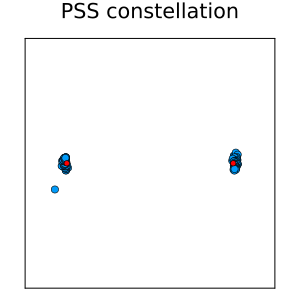

In [23]:
pss_sym_demod = 𝐹ₓ[pss_sc_sel];
constellation_plot(pss_sym_demod, title="PSS constellation")

In [24]:
# @show pss_sym_demod;

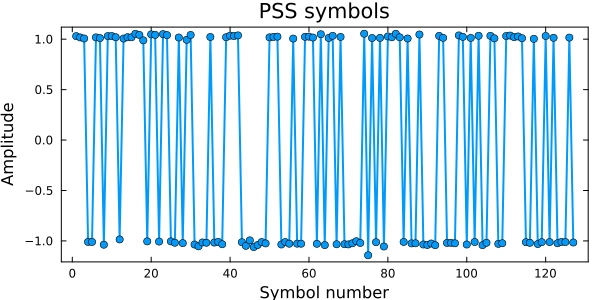

In [25]:
plot(real(pss_sym_demod)
    , marker=:circle
    , label=""
    , title = "PSS symbols"
    , xlabel = "Symbol number"
    , ylabel = "Amplitude"
    , linewidth=2
    , framestyle=:box
    , grid=:false
    , size = (600,300)
)

```julia
function pss_sequence()
```
Explanation:

`1:127`: This creates a range of indices from 1 to 127.

`.+ 43 * nid2`: This adds 43 * nid2 to each index in the range.

`.- 1`: This adjusts each resulting index by subtracting 1 to make the result zero-based temporarily
      , which is needed for the modulus operation.

`. % 127`: The modulus operation is applied to each index to ensure they wrap around 
      within a 0 to 126 range (127 elements).

`.+ 1`: After the modulus operation, 1 is added back to each index 
      to convert them back to Julia’s 1-based indexing.

```
Julia> return 1 .- 2 .* Float64.(x[mod1.((1:127) .+ 43 * nid2, 127)])
```
can also be used to comply with one-based index issue when using % (mod) operator

In [26]:
function pss_sequence(nid2::Int)
    x = zeros(UInt8, 127)  # Create an array of UInt8s initialized to zero
    # Initialize the first 7 bits in reverse order of the specific pattern
    x[1:7] = reverse([1, 1, 1, 0, 1, 1, 0]) 

    # Fill the rest of the array using LFSR ( linear feedback shift register) logic
    for j in 1:(127-7)
        x[j+7] = x[j+4] ⊻ x[j] # Apply XOR between the bits at positions j+4 and j
    end

    # map from {0,1} to {1,-1}
    return 1 .- 2 .* Float64.(x[((1:127) .+ 43 * nid2 .- 1) .% 127 .+ 1])

end

pss_sequence (generic function with 1 method)

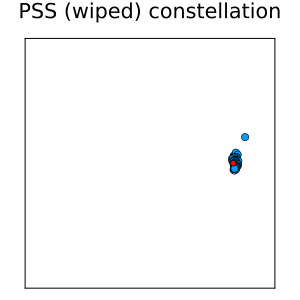

In [27]:
pss_sym_demod_wipe = float(pss_sym_demod) .* pss_sequence(1);
constellation_plot(pss_sym_demod_wipe, title="PSS (wiped) constellation", ref="pilot")

In [28]:
using Statistics
# phase error
angle(mean(pss_sym_demod_wipe))

0.0026765642507280947

## PSS time domain correlation

In [ ]:
# Initialize an empty array to store the plots
plots = Plots.Plot[]

for nid2 in 0:2
    
    pss_re = zeros(ComplexF64, Tu)
    pss_re[pss_sc_sel] = pss_sequence(nid2)
    pss_sym = ifft(fftshift(pss_re)); # @show pss_sym[1:10]

    pss_corr = zeros(ComplexF64, round(Int, 𝑓ₛ * 1e-3))
    time_corr_start = round(Int, 8.75e-3 * 𝑓ₛ); # @show time_corr_start, size(pss_corr)
    for j in 1:length(pss_corr)
        pss_corr[j] = sum( x[time_corr_start + j:end][1:Tu] .* conj(pss_sym) )
    end

    # Displaying in ms 
    # 1e3 *  (time_corr_start .+ (0:6780 - 1)) / fs => 8.75:0.00013020833333333333:9.632682291666667
    # Starting from 0 to length(pss_corr)
    tcorr = 1e3 *  (time_corr_start .+ (0:length(pss_corr) - 1)) / 𝑓ₛ; # @show tcorr[1:10], size(tcorr);
    plotₓ = plot(tcorr, abs.(pss_corr)
                , label=""
                , ylims=(0.0,0.3)
                , framestyle=:box
            ); # @show pss_corr[1:10];
    if nid2 == 0
        title!(plotₓ, "PSS Time Domain Correlation")
    elseif nid2 == 2
        xlabel!(plotₓ, "Time (ms)")
    end

    annotate!(plotₓ, tcorr[div(end, 16)], 0.15, text("\$N^{{\\mathrm{{(ID)}}}}_2\$ = $nid2", 8))
    push!(plots, plotₓ)

end

# Display the plots with a specific layout
plot(plots..., layout=(3, 1), legend=true, grid=:false)

## PSS time domain correlation

In [ ]:
NID2 = 1

In [ ]:
function sss_sequence(Nᵢ₋¹, Nᵢ₋², Onlyₓ¹=false, Noₓ¹=false, kargs...)
    x₀ = zeros(UInt8, 127)
    x₁ = zeros(UInt8, 127)
    x₀[1] = 1
    x₁[1] = 1

    for j in 1:120
        x₀[j + 7] = x₀[j + 4] ⊻ x₀[j]
        x₁[j + 7] = x₁[j + 1] ⊻ x₁[j]
    end

    if Onlyₓ¹
        return 1 .- 2 * Float64.(x₁)
    end

    m₀ = 15 * (Nᵢ₋¹ ÷ 112) + 5 * Nᵢ₋²
    m₁ = Nᵢ₋¹ % 112

    Iₓ⁰ = ((1:127) .+ m₀ .-1) .% 127 .+ 1
    Iₓ¹ = ((1:127) .+ m₁ .-1) .% 127 .+ 1

    if Noₓ¹
        return 1 .- 2 .* x₀[Iₓ⁰]
    else
        x = (1 .- 2 .* x₀[Iₓ⁰])
        y = (1 .- 2 .* x₁[Iₓ¹])
        return  x .* y            
    end

end

## SSS demodulation

In [ ]:
s_part = x[a₀ + 2 * (Ncp + Tu):end][1:Tu]; # @show s_part[1], size(s_part);

In [ ]:
𝐹ₓ = DSP.fftshift(DSP.fft(s_part)); # @show size(𝐹ₓ), 𝐹ₓ[1];
# Correct for the 5G NR upconversion discontinuity
# This PSS is transmitted on symbol 4 mod 7
𝐹ₓ .*= phase_corr[5]; @show phase_corr[5], 𝐹ₓ[1];

# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
𝐹ₓ .*= exp.(1im * 2π .* DSP.fftshift(DSP.fftfreq(Tu)) * Ncp / 2); @show 𝐹ₓ[1], size(𝐹ₓ);

In [ ]:
sss_sym_demod = 𝐹ₓ[pss_sc_sel]
constellation_plot(sss_sym_demod, title="SSS constellation")

In [ ]:
sss_corrs = zeros(ComplexF64, 336)
for j in 1:length(sss_corrs)
    sss_corrs[j] = mean(sss_sym_demod .* sss_sequence(j, NID2))
end

plot(abs.(sss_corrs)
    , title = "Correlation of SSS with SSS sequences for NID₂ = $NID2"
    , xlabel = "NID₁", ylabel = "Amplitude"
    , xlims  =(0.0, 350.0), ylims  =(0.0, 1.0)
    , legend = false, framestyle=:box
    , grid = :false
    , linewidth = 2
    , size = (600,300)
)

In [ ]:
# Initialize an empty array to store the plots
plots = Plots.Plot[]

fₓ¹ = fft(sss_sequence(1, 1, true, false))
for j in 0:2
    f_sss_demod = fft(sss_sym_demod .* sss_sequence(j * 112, NID2, false, true))
    corr_sss = ifft(f_sss_demod .* conj.(fₓ¹))
    plotₓ = plot(abs.(corr_sss), label="", framestyle=:box, linewidth=1.5, xticks = [])
    if j == 0
        title!(plotₓ, "Circular correlation of \$x_1\$ and SSS multiplied by \$x_0\$ sequences (\$N^{{\\mathrm{{(ID)}}}}_2\$ = $(NID2))", titlefontsize=10)
    elseif j == 2
        xlabel!(plotₓ, "Lag (symbols)")
        xticks!(0:20:120)
    end
    annotate!(plotₓ, 20, 80, text("\$x_0\$ for \$N^{{\\mathrm{{(ID)}}}}_2\$ = $(j * 112)", 10))
    push!(plots, plotₓ)
end
# Display the plots with a specific layout
plot(plots..., layout=(3, 1), legend=true, grid=:false, size = (600,350), ylims=(0,120), yticks=(0:100:120))

In [ ]:
NID1 = 0
NcellID = 3 * NID1 + NID2
NcellID

In [ ]:
sss_sym_demod_wipe = sss_sym_demod .* sss_sequence(NID1, NID2)

constellation_plot(sss_sym_demod_wipe, title="SSS (wiped) constellation", ref="pilot")

In [ ]:
# CFO error (Hz) using PSS and SSS
((angle(mean(sss_sym_demod_wipe)) - angle(mean(pss_sym_demod_wipe))) / 2π * 𝑓ₛ / (2 * (Tu + Ncp)))

## OFDM demodulation

In [ ]:
Nsymbols = round(Int, (length(x) - a₀) / (1e-3 * 𝑓ₛ) * 14)
# Nsymbols = Int((length(x) - a₀) / (1e-3 * 𝑓ₛ) * 14)
symbols = Array{ComplexF64}(undef, Nsymbols, Tu)
t_symbols = Vector{Float64}(undef, Nsymbols)
for j in 1:Nsymbols
    symidx = j + 1  # +1 since Julia is 1-based
    off =  a₀ + (j-1) * (Ncp + Tu) + div(symidx, 7) * (Ncpl - Ncp)
    off_err = (off - a₀) * sfo + sto_fine * 𝑓ₛ
    off_err_int = round(Int, off_err)
    off_err_frac = off_err - off_err_int
    off_corr = off + off_err_int
    f = fftshift(fft(x[off_corr:off_corr+Tu-1]))  # adjust for 1-based indexing
    f .*= phase_corr[(symidx % 7) + 1]  # use (symidx % 7) + 1 for 1-based indexing
    f .*= exp.(1im * 2 * π * fftshift(fftfreq(Tu)) * Ncp / 2)
    f .*= exp.(1im * 2 * π * fftshift(fftfreq(Tu)) * off_err_frac)
    symbols[j, :] = f
    t_symbols[j] = (off_corr + off_err_frac + Ncp / 2) / 𝑓ₛ
end

## Constellation plots

In [ ]:
function c_seq(init::Int, size::Int)
    crop = 1600
    x₁ = zeros(UInt8, crop + size)
    x₂ = zeros(UInt8, crop + size)
    x₁[1] = 1  # Julia arrays are 1-indexed

    for j in 0:30
        x₂[j + 1] = (init >> j) & 0x01
    end

    for j in 1:(length(x₁) - 31)
        x₁[j + 31] = x₁[j + 3] ⊻ x₁[j]
        x₂[j + 31] = x₂[j + 3] ⊻ x₂[j + 2] ⊻ x₂[j + 1] ⊻ x₂[j]
    end

    return x₁[crop + 1:end] .⊻ x₂[crop + 1:end]  # Apply XOR to the sliced arrays
end

In [ ]:
@show NcellID

In [ ]:
# Assuming the c_seq function from the earlier message is defined in your Julia environment
# and ensuring that NcellID and other variables are already defined.

issb = 0
# Compute the seed using bit shifts and arithmetic, adjusting for Julia's use of div() and bitwise operations
pbch_dmrs_seq = c_seq(2^11 * (issb + 1) * (div(NcellID, 4) + 1) + 2^6 * (issb + 1) + (NcellID % 4), 288)

# Convert the generated sequence for use in PBCH DMRS
# Normalize the sequence by sqrt(2) and create the complex sequence
factor = 1 / sqrt(2)
pbch_dmrs_seq = factor * ((1 .- 2 .* Float64.(pbch_dmrs_seq[1:2:end])) + 
                          1im * (1 .- 2 .* Float64.(pbch_dmrs_seq[2:2:end])));

In [ ]:
Nssblocks = Nsymbols ÷ 140  # Integer division
plot_width = 4
axs = plot(layout = (Nssblocks, 3), size = (plot_width * 100, plot_width * Nssblocks ÷ 3 * 100))

for j in 1:Nssblocks
    s0 = (j-1) * 140 + 1  # Adjusted for 1-based indexing
    pss = symbols[s0, pss_sc_sel] .* pss_sequence(NID2)
    sss = symbols[s0 + 2, pss_sc_sel] .* sss_sequence(NID1, NID2)
    pbch = vcat(
        symbols[s0 + 1, Tu ÷ 2 - 120:Tu ÷ 2 + 120 - 1],
        symbols[s0 + 2, Tu ÷ 2 - 120:Tu ÷ 2 - 120 + 48 - 1],
        symbols[s0 + 2, Tu ÷ 2 - 120 + 192:Tu ÷ 2 + 120 - 1],
        symbols[s0 + 3, Tu ÷ 2 - 120:Tu ÷ 2 + 120 - 1]
    )
    pbch_dmrs = pbch[(NcellID % 4) + 1:4:end]  # Adjusted slicing
    pbch_dmrs_wipe = pbch_dmrs .* conj.(pbch_dmrs_seq)  # Element-wise conjugate multiplication
    pbch_data = pbch[[(i % 4) + 1 != (NcellID % 4) + 1 for i in 0:length(pbch)-1]]  # Filtering
    constellation_plot(pss, ax=axs[3*(j-1)+1], ref="pilot")
    constellation_plot(sss, ax=axs[3*(j-1)+2], ref="pilot")
    constellation_plot(pbch_data, ax=axs[3*(j-1)+3], ref="qpsk")
    constellation_plot(pbch_dmrs_wipe, ax=axs[3*(j-1)+3], ref="pilot") # , color=:green)
end

plot!(axs, layout = (Nssblocks, 3)
    , size = (plot_width * 100, plot_width * Nssblocks ÷ 3 * 100)
    , legend=:false
)
plot!(title = "SS/PBCH demodulation", subplot = (1, 1))